### Output for manuscript

__Purpose:__ Make charts for an article about the experience of EPFL students and beach litter surveys.

__Background:__ This is in the context of the global movement to reduce plastic debris in the maritime environment. Riverine inputs are major contributors of plastic debris (and all types of refuse) to the oceans. This parts of an analysis of the data collected on the shores of Lake Geneva over a three year period. The maritime protocol was modified in very specific ways to adjust for the local geography and population density.

#### From previous notebooks in this repo:

1. The data was collected at different locations
2. The data was collected by different groups of people
3. For each year there is one group that collected 50% or more of the samples
4. The mean for each year is 9pcs/m +/- 1
5. The median for each year is 5.5pcs/m +/- 1.3
6. The numnber of samples for each year is different
7. Each year has a geographic center
8. All the particpants recieved training on a standardized protocol

#### The survey totals, in pieces of trash per meter, can be summarised as follows:


| Statistic     | Year one | Year two | Year three | Combined   |   
|--------------:|:--------:|:--------:|:----------:|:-----:|
| __Samples__   | <span style="color:red">83</span>       |41        |24          | 148   |
| __mean__      | 8.77     |<span style="color:red">9.99</span>      |9.01        | 9.16  |
| __median__    | 4.83     |<span style="color:red">6.84</span>     |4.24        | 5.52  |
| __Std dev__   | 9.92     |8.52      |<span style="color:red">16.14</span>      |10.75  |
| __25\%ile__   | 3.113    |<span style="color:red">4.41</span>     |2.36        | 3.18  |
| __75\%ile__   | 10.405   |<span style="color:red">12.35</span>    |7.79        | 11.24 | 
| __Minimum__   | 0.68   |0.57      |<span style="color:red">0.11 </span>        | 0.11  | 
| __Maximum__   | 50.075   |39.54     |<span style="color:red">77.05 </span>      | 77.05| 
| _MCBP samples_   |<span style="color:red">80</span>  |<span style="color:red">22</span>    |5   | <span style="color:red">107</span>| 
| _SLR samples_   |0  |18    |<span style="color:red">15</span>      | 33|
| _EPFL samples_  |2 |2     |2| 6| 
| _PC samples_  | 0 |0   |2       | 2| 


In [1]:
# import numpy as np
import json
import csv
import datetime
import collections
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import cm
from matplotlib import colors as mcolors
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from Utilities.utility_functions import *

In [2]:
# The data is off of the API at https://mwshovel.pythonanywhere.com/dirt/api_home.html 
# You will have the opportunity to save the data locally
# get some file structures in place

# Required variables:
folders = ["Data", "Charts", "Utilities"]
here = os.getcwd()

# check for existing and if not make folders
check_for_folders(folders, here)

# make a dictionary to call path by directory name
my_folders = make_folders(folders, here)

Directory already in place


In [3]:
# Read the JSON data in from local
# there is no need to hit the server a million times

# required variables
the_jsons = [
    '/home/mw-shovel/three_year_final/Data/beach_info.json',
    '/home/mw-shovel/three_year_final/Data/all_data.json'
]

idx = pd.IndexSlice
# all the survey results by code, location, date, project:
my_survey_results = jsonFileGet(the_jsons[1])
def changeProjectName(aList, otherList, projectName):
    aNewList = []   
    for eachDict in aList:       
        if eachDict["location_id"] in otherList:
            eachDict['project_id'] = projectName
            aNewList.append(eachDict)
        else:
            aNewList.append(eachDict)
    return aNewList
            
location_list = ["Plage-de-St-Sulpice", "Parc-des-Pierrettes",  "Tiger-duck-beach", "Saint-Sulpice"]
project_name = "tiger-duck"
my_survey_resultsx = changeProjectName(my_survey_results, location_list, project_name)

# all the location information:
beach_info = jsonFileGet(the_jsons[0])

code_description = pd.read_csv("Data/mlw_code_defs.csv").to_dict(orient="records")
code_describe = {x["code"]:[x["material"],x["description"],x["source"]] for x in code_description}
code_describe["G178"] = ['Metal', 'Metal bottle caps & lids', 'Food']

# make a data frame:
the_survey_results = pd.DataFrame(my_survey_resultsx)    

In [4]:
# making a pcs/m column:

the_survey_results["pcs_m"] = the_survey_results["quantity"]/the_survey_results["length"]

# making a month, day and year column from a datetime object
# makes sorting easier
the_survey_results["py_date"] = pd.to_datetime(the_survey_results["date"])
the_survey_results["py_month"] = the_survey_results["py_date"].dt.month
the_survey_results["py_year"] = the_survey_results["py_date"].dt.year
the_survey_results["py_day"] = the_survey_results["py_date"].dt.weekday

In [5]:
#### one df for abundance and one df for density:
abundance = the_survey_results[["project_id", "location_id", "date","py_date", "py_month", "py_year", "code_id", "quantity"]].copy()
density = the_survey_results[["project_id", "location_id", "date","py_date", "py_day","py_month", "py_year", "code_id", "pcs_m"]].copy()
start_date = datetime.datetime.strptime("2015-11-15", "%Y-%m-%d")
end_date = datetime.datetime.strptime("2017-11-14", "%Y-%m-%d")

In [6]:
colors = [
    "midnightblue",
    "darkblue",
    "blue",
    "darkslateblue",
    "mediumpurple",
    "blueviolet",
    "darkorchid",
    "mediumorchid",
    "plum",
    "purple",
    "fuchsia",
    "skyblue",
    "steelblue",
    "darkseagreen",
    "lightgreen",
    "chocolate",
    "darkolivegreen",
    "maroon",
    "tomato",
    "black"
]
color_maps = [
    'binary',
    'gist_yarg',
    'gist_gray',
    'gray',
    'bone',
    'pink',
    'spring',
    'summer',
    'autumn',
    'winter',
    'cool',
    'Wistia',
    'hot',
    'afmhot',
    'gist_heat',
    'copper'
]
this_map='PuBuGn'
def percentOfTotalAndFrequency(quantDict, freqDict, total, num_samps):
    new_dict = {} 
    for k,v in quantDict.items():
        freq = freqDict[k]
        new_dict.update({k:[v,v/total,freq,freq/num_samps]})
    return new_dict
def quantityFrequency(quant, freq, codes):
    qVsF = []
    for code in codes:
        qVsF.append([code, quant[code], freq[code]])
    return qVsF
def getDataByDateRange(data, end_start):
    this_data = data[(data['py_date'] >= end_start[0][0]) & (data['py_date'] <= end_start[0][1])]
    return this_data
def getCodeTotalsFromDateRange(data):
    return data.groupby(['code_id'])["quantity"].aggregate(np.sum).sort_values(ascending=False)
def getCodeFrequencyFromDateRange(data):
    return data.groupby(["code_id"])['code_id'].count().sort_values(ascending=False)
def getNumSamps(data):
    return data[['location_id', 'py_date','quantity']].groupby(['location_id', 'py_date']).sum().count().values[0]
def getTuplesFromSeries(data):
    return list(zip(data.index, data))
def getTheRest(aList, total_quant):
    some_number = 0
    for x in aList:
        some_number += x[1]
    return total_quant - some_number
def makeBlocks(the_data_study, percent, end_start, total_quant):    
    code_totals = getCodeTotalsFromDateRange(the_data_study)
    code_totals_tuple = getTuplesFromSeries(code_totals)
    code_greater_than = [
        (x[0],x[1],colors[i],code_describe[x[0]][1])
        for i,x in enumerate(code_totals_tuple)
        if x[1] >= percent
    ]
    the_rest = getTheRest(code_greater_than, total_quant)
    code_greater_than.append(("Other", the_rest,"thistle", "*All other objects"))
    return code_greater_than

In [7]:
# required variables
step = 2000
# title and sup title
title_color = "black"
min_date = "Nov-2015"
max_date = "Nov-2017"
# n_samples = len(code_greater_than)
font_styles = {
    'fontsize': 12,
    'fontfamily':'sans-serif',
    'fontweight' : 'normal',
    'verticalalignment': 'baseline',
    'horizontalalignment': 'center'
}
title_text = "All objects found"
sub_title_text = "Lake Geneva"
pad = 15
# legend
b_box = (1,1.02)
frameAlpha=1
frameEdgeColor="black"
loc="best"
legend_title_size = 14
legend_font_size = 11
# labels
y_label_size = 12
y_label_color = "black"
y_label_padding = 15
# annotate
data_coords = (-0.2, 5.66)
text_coords = (-0.25, 35)
connection_style="arc3, rad=0.3"
# plots
opac=0.5
marker_size = 10
edge_color = "#ffffff"
flierprops = dict(marker='o', markersize=6, markerfacecolor='black')
top_adjust=0.87
# storing output
file_prefix = my_folders["Charts"]
file_suffix = [
    '.svg',
    '.png',    
]
file_names="fig_9_optional"
# category colors
PROJECT_COLORS = [
    "indigo",
    "darkcyan",
    "olive",
    "darkred",
    
]
color = "wheat"

In [8]:
def iterateBarchartBlocks(the_data_study, percent, end_start, title_text, sub_title_text):
    fig, ax = plt.subplots(figsize=(3,6))
    my_cmap = plt.cm.get_cmap(this_map,100)
    
    
    the_data_for_study = getDataByDateRange(the_data_study, end_start)
    total_quant = the_data_for_study.quantity.sum()
    
    projects = the_data_for_study.project_id.unique()
    project_colors = dict(zip(projects, PROJECT_COLORS))
    
    y_limit = total_quant
    y_max = y_limit + 2
    the_percent = total_quant*percent
    
    title = "{},  total={:,}".format(title_text, total_quant)
    sub_title = '{}, {} - {}'.format(sub_title_text, min_date, max_date)
   
    
    the_bottom = 0
    the_data = makeBlocks(the_data_for_study, the_percent, end_start, total_quant)
    color=iter(my_cmap(np.linspace(.2,.75,len(the_data))))
   
    for i,block in enumerate(the_data):
       
        if i == 0:            
            ax.bar(1, block[1], color=next(color), edgecolor="white", alpha=0.9,
                    label="{}: {:,}".format(block[3],block[1]))
            the_bottom += block[1]
        else:            
            ax.bar(1, block[1], color=next(color), edgecolor="white",alpha=0.9,
                   bottom=the_bottom,
                   label="{}: {:,}".format(block[3],block[1]))
            the_bottom += block[1]
    plt.subplots_adjust(top=top_adjust)
    plt.xticks([0])
    plt.ylim(0, y_max)
    plt.ylabel('Number of objects found',fontfamily="sans-serif", labelpad=y_label_padding, color=y_label_color, size=y_label_size)
    plt.xlabel("*Identified items equal to less than 1% of the total.\nCaps and lids are plastic unless noted.", fontfamily="sans-serif", labelpad=y_label_padding, color=y_label_color, size=y_label_size, ha="left", x=0)
    plt.suptitle(title, fontfamily="sans-serif", fontweight="roman", fontsize=14, x=0.13, ha="left", color=title_color)
    plt.title(sub_title, fontdict=font_styles, pad=pad, x=0, ha="left", color=title_color)
    handles, labels = ax.get_legend_handles_labels()
    this = ax.legend(handles[::-1], labels[::-1], title='Object description: quantity',title_fontsize=legend_title_size, fontsize=legend_font_size, bbox_to_anchor=b_box, loc='upper left')
    this._legend_box.align = "left"
    for x in file_suffix:
        save_me = '{}/{}{}'.format(file_prefix, file_names, x)
        plt.savefig(save_me, bbox_inches="tight")     
    plt.show()
    plt.close()  

### Cumulative results Lac Léman Nov 2015 - Nov 2017

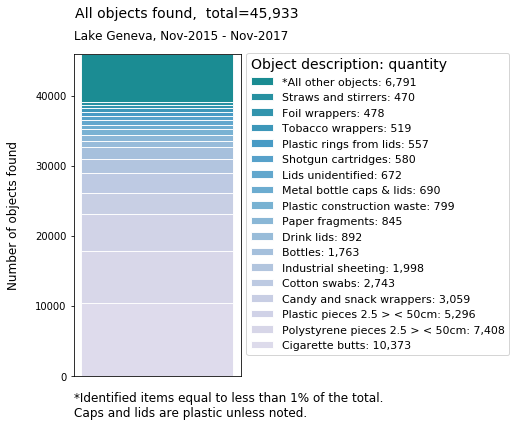

In [9]:
iterateBarchartBlocks(abundance, .01, [(start_date, end_date)], title_text, sub_title_text)

### Cumulative results Saint Sulpice and Parc Parc-des-Pierrettes

In [10]:
# results for the locations of interest
# the columns:
# ["project_id", "location_id", "date","py_date", "py_month", "py_year", "code_id", "quantity"]
day_of_interest = "2017-10-05"
date_of_interest = datetime.datetime.strptime("2017-10-05", "%Y-%m-%d")
end_date = datetime.datetime.strptime("2017-10-06", "%Y-%m-%d")
loc_of_interest = [ "Parc-des-Pierrettes", "Plage-de-St-Sulpice"]
parc_des_pierrettes_a = abundance.loc[(abundance.location_id == "Parc-des-Pierrettes") & (abundance.py_date < end_date)]
saint_sulpice_a = abundance.loc[(abundance.location_id == "Plage-de-St-Sulpice") & (abundance.py_date < end_date)]

parc_des_pierrettes_day = abundance.loc[(abundance.location_id == "Parc-des-Pierrettes") & (abundance.py_date == date_of_interest)]
saint_sulpice_day = abundance.loc[(abundance.location_id == "Plage-de-St-Sulpice") & (abundance.py_date == date_of_interest)]

# group by code id
p_d_p_code_group = getCodeTotalsFromDateRange(parc_des_pierrettes_a)
s_s_code_group = getCodeTotalsFromDateRange(saint_sulpice_a)


# get the top ten, the total quantity found and the total of the top ten for the two locations of interest:
p_d_p_top_ten = p_d_p_code_group[:10]
p_d_p_total = p_d_p_code_group.sum()
p_d_p_top_total = p_d_p_top_ten.sum()
s_s_top_ten = s_s_code_group[:10]
s_s_total = s_s_code_group.sum()
s_s_top_total = s_s_top_ten.sum()

# the make blocks function needs to be modified a little:
def makeBlocks(the_data,total_quant, top_quant):    
    code_totals_tuple = getTuplesFromSeries(the_data)
    code_greater_than = [
        (x[0],x[1],code_describe[x[0]][1])
        for i,x in enumerate(code_totals_tuple)       
    ]    
    the_rest = total_quant - top_quant
    code_greater_than.append(("Other", the_rest,"*All other objects"))
    return code_greater_than
p_d_p_top_blox = makeBlocks(p_d_p_top_ten, p_d_p_total,p_d_p_top_total )
s_s_top_blox = makeBlocks(s_s_top_ten,s_s_total,s_s_top_total )

In [11]:
# this needs to be changed a little
file_names="fig_9_opt_ss_all_top_ten"
def iterateNewBarchartBlocks(the_data_study, total_quant, min_date, max_date, title_text, sub_title_text):
    fig, ax = plt.subplots(figsize=(3,6))
    my_cmap = plt.cm.get_cmap(this_map,100)
    total_quant = total_quant
    y_limit = total_quant
    y_max = y_limit + 2
    title = "{},  total={:,}".format(title_text, total_quant)
    sub_title = '{}, {} - {}'.format(sub_title_text, min_date, max_date)
    the_bottom = 0
    the_data = the_data_study
    color=iter(my_cmap(np.linspace(.2,.75,len(the_data))))   
    for i,block in enumerate(the_data):       
        if i == 0:            
            ax.bar(1, block[1], color=next(color), edgecolor="white", alpha=0.9,
                    label="{}: {:,}".format(block[2],block[1]))
            the_bottom += block[1]
        else:            
            ax.bar(1, block[1], color=next(color), edgecolor="white",alpha=0.9,
                   bottom=the_bottom,
                   label="{}: {:,}".format(block[2],block[1]))
            the_bottom += block[1]
    plt.subplots_adjust(top=top_adjust)
    plt.xticks([0])
    plt.ylim(0, y_max)
    plt.ylabel('Number of objects found',fontfamily="sans-serif", labelpad=y_label_padding, color=y_label_color, size=y_label_size)
    plt.xlabel("*Identified items not in the top ten.\nCaps and lids are plastic unless noted.", fontfamily="sans-serif", labelpad=y_label_padding, color=y_label_color, size=y_label_size, ha="left", x=0)
    plt.suptitle(title, fontfamily="sans-serif", fontweight="roman", fontsize=14, x=0.13, ha="left", color=title_color)
    plt.title(sub_title, fontdict=font_styles, pad=pad, x=0, ha="left", color=title_color)
    handles, labels = ax.get_legend_handles_labels()
    this = ax.legend(handles[::-1], labels[::-1], title='Object description: quantity',title_fontsize=legend_title_size, fontsize=legend_font_size, bbox_to_anchor=b_box, loc='upper left')
    this._legend_box.align = "left"
    for x in file_suffix:
        save_me = '{}/{}{}'.format(file_prefix, file_names, x)
        plt.savefig(save_me, bbox_inches="tight")     
    plt.show()
    plt.close()  

#### The top ten Plage de Saint Sulpice

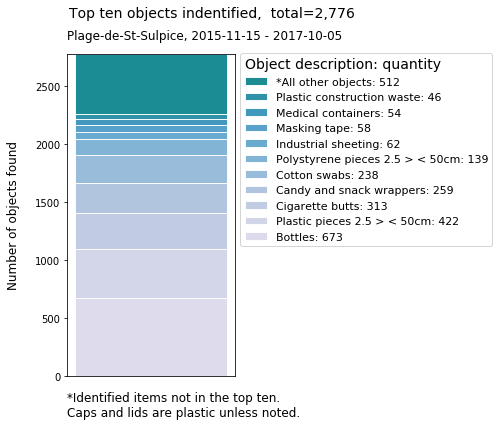

In [12]:
# the variables:
# the_data_study, total_quant, min_date, max_date, title_text, sub_title_text
iterateNewBarchartBlocks(
    s_s_top_blox,s_s_total,
    "2015-11-15",day_of_interest,
    "Top ten objects indentified",
    loc_of_interest[1]
)

#### The top ten Parc des Pierrettes

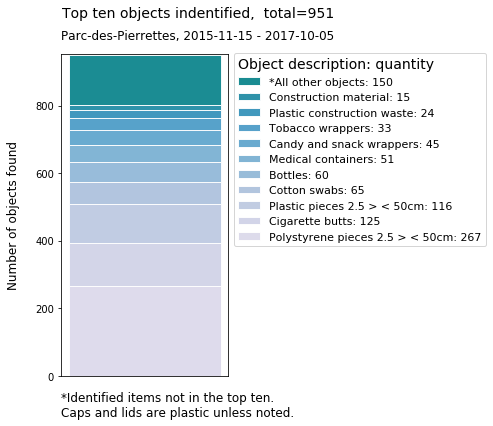

In [13]:
file_names="fig_9_opt_pdp_all_top_ten"
iterateNewBarchartBlocks(
    p_d_p_top_blox,
    p_d_p_total,
    "2015-11-15",
    day_of_interest,
    "Top ten objects indentified",
    loc_of_interest[0]
)

#### Material Parc des Pierrettes

In [14]:
# make a grouper for the material
def makeMaterialDict(aDict):
    what_i_want = {"Plastic":[], "Rubber":[], "Wood":[], "Metal":[], "Paper":[], "Cloth":[], "Glass":[]}
    for key,value in aDict.items():
        if value[0] in what_i_want.keys():
            what_i_want[value[0]].append(key)
    return what_i_want
material_groups = makeMaterialDict(code_describe)

def makeMaterialTotals(data, material_groups):
    what_i_want = {"Plastic":0, "Rubber":0, "Wood":0, "Metal":0, "Paper":0, "Cloth":0, "Glass":0}
    code_totals_tuple = getTuplesFromSeries(data)
    for x in code_totals_tuple:
        for key, value in material_groups.items():
            if x[0] in value:
                what_i_want[key] += x[1]
    return what_i_want
pdp_material_block = makeMaterialTotals(p_d_p_code_group, material_groups)
s_s_material_block = makeMaterialTotals(s_s_code_group, material_groups)

In [15]:
def iterateMaterialBarchartBlocks(the_data_study, total_quant, min_date, max_date, title_text, sub_title_text):
    fig, ax = plt.subplots(figsize=(3,6))
    my_cmap = plt.cm.get_cmap(this_map,100)
    total_quant = total_quant
    y_limit = total_quant
    y_max = y_limit + 2
    title = "{},  total={:,}".format(title_text, total_quant)
    sub_title = '{}, {} - {}'.format(sub_title_text, min_date, max_date)
    the_bottom = 0
    the_data = [(key,value) for key, value in the_data_study.items()]
    the_data = sorted(the_data, key=lambda x: -x[1])
    color=iter(my_cmap(np.linspace(.2,.75,len(the_data))))   
    for i,block in enumerate(the_data):       
        if i == 0:            
            ax.bar(1, block[1], color=next(color), edgecolor="white", alpha=0.9,
                    label="{}: {:}".format(block[0],block[1]))
            the_bottom += block[1]
        else:            
            ax.bar(1, block[1], color=next(color), edgecolor="white",alpha=0.9,
                   bottom=the_bottom,
                   label="{}: {:}".format(block[0],block[1]))
            the_bottom += block[1]
    plt.subplots_adjust(top=top_adjust)
    plt.xticks([0])
    plt.ylim(0, y_max)
    plt.ylabel('Number of objects found',fontfamily="sans-serif", labelpad=y_label_padding, color=y_label_color, size=y_label_size)
#     plt.xlabel("*Identified items not in the top ten.\nCaps and lids are plastic unless noted.", fontfamily="sans-serif", labelpad=y_label_padding, color=y_label_color, size=y_label_size, ha="left", x=0)
    plt.suptitle(title, fontfamily="sans-serif", fontweight="roman", fontsize=14, x=0.13, ha="left", color=title_color)
    plt.title(sub_title, fontdict=font_styles, pad=pad, x=0, ha="left", color=title_color)
    handles, labels = ax.get_legend_handles_labels()
    this = ax.legend(handles[::-1], labels[::-1], title='Material: quantity',title_fontsize=legend_title_size, fontsize=legend_font_size, bbox_to_anchor=b_box, loc='upper left')
    this._legend_box.align = "left"
#     for x in file_suffix:
#         save_me = '{}/{}{}'.format(file_prefix, file_names, x)
#         plt.savefig(save_me, bbox_inches="tight")     
    plt.show()
    plt.close()  

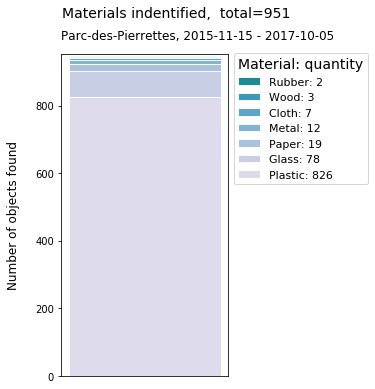

In [16]:
# the variables:
# iterateMaterialBarchartBlocks(the_data_study, min_date, max_date, title_text, sub_title_text)
file_names="fig_9_opt_pp_all_material"
iterateMaterialBarchartBlocks(
    pdp_material_block,
    p_d_p_total,
    "2015-11-15",
    day_of_interest,
    "Materials indentified",
    loc_of_interest[0]
)

#### Material Saint Sulpice

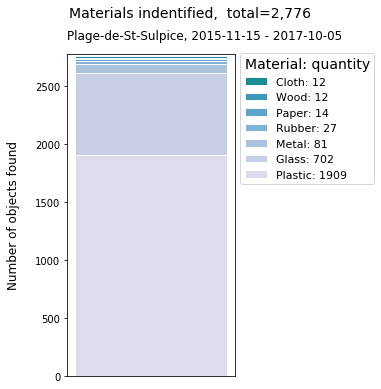

In [17]:
file_names="fig_9_opt_ss_all_material"
iterateMaterialBarchartBlocks(
    s_s_material_block ,
    s_s_total,
    "2015-11-15",
    day_of_interest,
    "Materials indentified",
    loc_of_interest[1]
)

#### Source Parc des Pierrettes

In [18]:
# get the source keys

my_sources = [value[2] for key,value in code_describe.items()]
my_sources = list(np.unique(my_sources))
my_sources.remove('None')

def makeSourceDict(aDict, my_sources):
    what_i_want ={x:[] for x in my_sources}
    for key,value in aDict.items():
        if value[2] in what_i_want.keys():
            what_i_want[value[2]].append(key)
    return what_i_want
source_groups = makeSourceDict(code_describe,my_sources)

def makeSourceTotals(data, material_groups):
    what_i_want = {x:0 for x in material_groups}
    code_totals_tuple = getTuplesFromSeries(data)
    for x in code_totals_tuple:
        for key, value in material_groups.items():
            if x[0] in value:
                what_i_want[key] += x[1]
    return what_i_want

pdp_source_block = makeSourceTotals(p_d_p_code_group, source_groups)
s_s_source_block = makeSourceTotals(s_s_code_group, source_groups)

In [19]:
def iterateSourceBarchartBlocks(the_data_study, total_quant, min_date, max_date, title_text, sub_title_text):
    fig, ax = plt.subplots(figsize=(3,6))
    my_cmap = plt.cm.get_cmap(this_map,100)
    total_quant = total_quant
    y_limit = total_quant
    y_max = y_limit + 2
    title = "{},  total={:,}".format(title_text, total_quant)
    sub_title = '{}, {} - {}'.format(sub_title_text, min_date, max_date)
    the_bottom = 0
    the_data = [(key,value) for key, value in the_data_study.items()]
    the_data = sorted(the_data, key=lambda x: -x[1])
    color=iter(my_cmap(np.linspace(.2,.75,len(the_data))))   
    for i,block in enumerate(the_data):       
        if i == 0:            
            ax.bar(1, block[1], color=next(color), edgecolor="white", alpha=0.9,
                    label="{}: {:}".format(block[0],block[1]))
            the_bottom += block[1]
        else:            
            ax.bar(1, block[1], color=next(color), edgecolor="white",alpha=0.9,
                   bottom=the_bottom,
                   label="{}: {:}".format(block[0],block[1]))
            the_bottom += block[1]
    plt.subplots_adjust(top=top_adjust)
    plt.xticks([0])
    plt.ylim(0, y_max)
    plt.ylabel('Number of objects found',fontfamily="sans-serif", labelpad=y_label_padding, color=y_label_color, size=y_label_size)
#     plt.xlabel("*Identified items not in the top ten.\nCaps and lids are plastic unless noted.", fontfamily="sans-serif", labelpad=y_label_padding, color=y_label_color, size=y_label_size, ha="left", x=0)
    plt.suptitle(title, fontfamily="sans-serif", fontweight="roman", fontsize=14, x=0.13, ha="left", color=title_color)
    plt.title(sub_title, fontdict=font_styles, pad=pad, x=0, ha="left", color=title_color)
    handles, labels = ax.get_legend_handles_labels()
    this = ax.legend(handles[::-1], labels[::-1], title='Source: quantity',title_fontsize=legend_title_size, fontsize=legend_font_size, bbox_to_anchor=b_box, loc='upper left')
    this._legend_box.align = "left"
#     for x in file_suffix:
#         save_me = '{}/{}{}'.format(file_prefix, file_names, x)
#         plt.savefig(save_me, bbox_inches="tight")     
    plt.show()
    plt.close()  

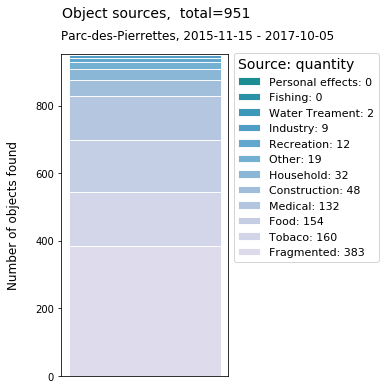

In [20]:
file_names="fig_9_opt_pp_all_source"
iterateSourceBarchartBlocks(
    pdp_source_block,
    p_d_p_total,
    "2015-11-15",
    day_of_interest,
    "Object sources",
    loc_of_interest[0]
)

#### Source Saint Sulpice

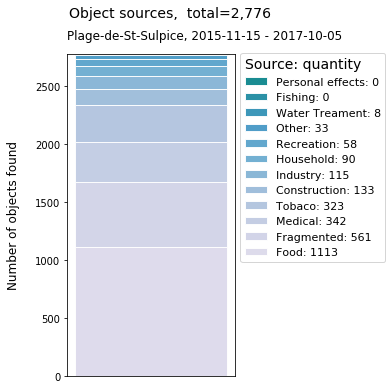

In [21]:
file_names="fig_9_opt_ss_all_source"
iterateSourceBarchartBlocks(
    s_s_source_block,
    s_s_total,
    "2015-11-15",
    day_of_interest,
    "Object sources",
    loc_of_interest[1]
)

### Results on the day of interest

In [22]:
p_d_p_day_code = getCodeTotalsFromDateRange(parc_des_pierrettes_day )
s_s_day_code = getCodeTotalsFromDateRange(saint_sulpice_day )
p_d_p_top_ten_day = p_d_p_day_code[:10]
p_d_p_total_day = p_d_p_day_code.sum()
p_d_p_top_total_day = p_d_p_top_ten_day .sum()
s_s_top_ten_day = s_s_day_code[:10]
s_s_total_day= s_s_day_code.sum()
s_s_top_total_day = s_s_top_ten_day.sum()

In [23]:
# makeBlocks(the_data,total_quant, top_quant):

p_d_p_top_blox_day = makeBlocks(p_d_p_top_ten_day, p_d_p_total_day,p_d_p_top_total_day  )
s_s_top_blox_day = makeBlocks(s_s_top_ten_day,s_s_total_day,s_s_top_total_day )

In [24]:
def iterateDailychartBlocks(the_data_study, total_quant, date, title_text, sub_title_text):
    fig, ax = plt.subplots(figsize=(3,6))
    my_cmap = plt.cm.get_cmap(this_map,100)
    total_quant = total_quant
    y_limit = total_quant
    y_max = y_limit + 2
    title = "{},  total={:,}".format(title_text, total_quant)
    sub_title = '{}, {}'.format(sub_title_text, date)
    the_bottom = 0
    the_data = the_data_study
    color=iter(my_cmap(np.linspace(.2,.75,len(the_data))))   
    for i,block in enumerate(the_data):       
        if i == 0:            
            ax.bar(1, block[1], color=next(color), edgecolor="white", alpha=0.9,
                    label="{}: {:,}".format(block[2],block[1]))
            the_bottom += block[1]
        else:            
            ax.bar(1, block[1], color=next(color), edgecolor="white",alpha=0.9,
                   bottom=the_bottom,
                   label="{}: {:,}".format(block[2],block[1]))
            the_bottom += block[1]
    plt.subplots_adjust(top=top_adjust)
    plt.xticks([0])
    plt.ylim(0, y_max)
    plt.ylabel('Number of objects found',fontfamily="sans-serif", labelpad=y_label_padding, color=y_label_color, size=y_label_size)
    plt.xlabel("*Identified items not in the top ten.\nCaps and lids are plastic unless noted.", fontfamily="sans-serif", labelpad=y_label_padding, color=y_label_color, size=y_label_size, ha="left", x=0)
    plt.suptitle(title, fontfamily="sans-serif", fontweight="roman", fontsize=14, x=0.13, ha="left", color=title_color)
    plt.title(sub_title, fontdict=font_styles, pad=pad, x=0, ha="left", color=title_color)
    handles, labels = ax.get_legend_handles_labels()
    this = ax.legend(handles[::-1], labels[::-1], title='Object description: quantity',title_fontsize=legend_title_size, fontsize=legend_font_size, bbox_to_anchor=b_box, loc='upper left')
    this._legend_box.align = "left"
#     for x in file_suffix:
#         save_me = '{}/{}{}'.format(file_prefix, file_names, x)
#         plt.savefig(save_me, bbox_inches="tight")     
    plt.show()
    plt.close()  

#### Top ten Parc des Pierrettes

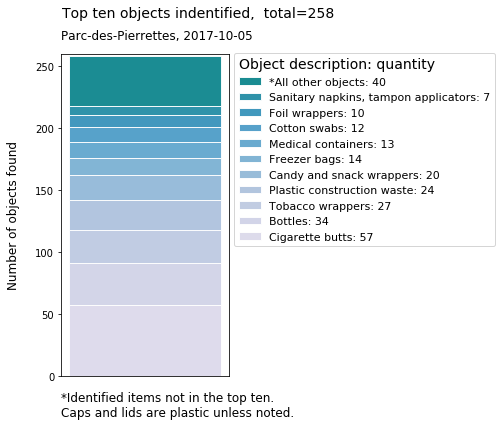

In [25]:
file_names="fig_9_pp_top_ten"
iterateDailychartBlocks(
    p_d_p_top_blox_day,p_d_p_total_day,
    day_of_interest,
    "Top ten objects indentified",
    loc_of_interest[0]
)

#### Top ten Saint Sulpice

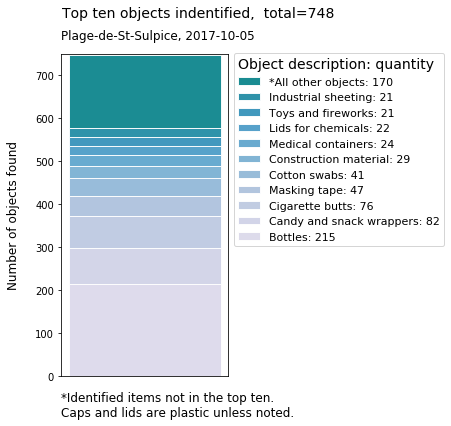

In [26]:
file_names="fig_9_ss_top_ten"
iterateDailychartBlocks(
    s_s_top_blox_day,s_s_total_day,
    day_of_interest,
    "Top ten objects indentified",
    loc_of_interest[1]
)

In [27]:
pdp_material_block_d = makeMaterialTotals(p_d_p_day_code, material_groups)
s_s_material_block_d = makeMaterialTotals(s_s_day_code, material_groups)

In [28]:
def iterateMaterialBarchartBlocksDay(the_data_study, total_quant,date, title_text, sub_title_text):
    fig, ax = plt.subplots(figsize=(3,6))
    my_cmap = plt.cm.get_cmap(this_map,100)
    total_quant = total_quant
    y_limit = total_quant
    y_max = y_limit + 2
    title = "{},  total={:,}".format(title_text, total_quant)
    sub_title = '{}, {}'.format(sub_title_text, date)
    the_bottom = 0
    the_data = [(key,value) for key, value in the_data_study.items()]
    the_data = sorted(the_data, key=lambda x: -x[1])
    color=iter(my_cmap(np.linspace(.2,.75,len(the_data))))   
    for i,block in enumerate(the_data):       
        if i == 0:            
            ax.bar(1, block[1], color=next(color), edgecolor="white", alpha=0.9,
                    label="{}: {:}".format(block[0],block[1]))
            the_bottom += block[1]
        else:            
            ax.bar(1, block[1], color=next(color), edgecolor="white",alpha=0.9,
                   bottom=the_bottom,
                   label="{}: {:}".format(block[0],block[1]))
            the_bottom += block[1]
    plt.subplots_adjust(top=top_adjust)
    plt.xticks([0])
    plt.ylim(0, y_max)
    plt.ylabel('Number of objects found',fontfamily="sans-serif", labelpad=y_label_padding, color=y_label_color, size=y_label_size)
#     plt.xlabel("*Identified items not in the top ten.\nCaps and lids are plastic unless noted.", fontfamily="sans-serif", labelpad=y_label_padding, color=y_label_color, size=y_label_size, ha="left", x=0)
    plt.suptitle(title, fontfamily="sans-serif", fontweight="roman", fontsize=14, x=0.13, ha="left", color=title_color)
    plt.title(sub_title, fontdict=font_styles, pad=pad, x=0, ha="left", color=title_color)
    handles, labels = ax.get_legend_handles_labels()
    this = ax.legend(handles[::-1], labels[::-1], title='Material: quantity',title_fontsize=legend_title_size, fontsize=legend_font_size, bbox_to_anchor=b_box, loc='upper left')
    this._legend_box.align = "left"
#     for x in file_suffix:
#         save_me = '{}/{}{}'.format(file_prefix, file_names, x)
#         plt.savefig(save_me, bbox_inches="tight")     
    plt.show()
    plt.close()  

#### Materials Saint Sulpice

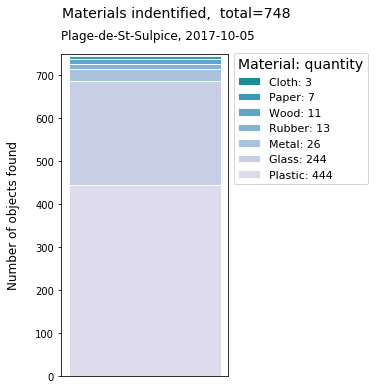

In [29]:
file_names="fig_9_ss_material"
iterateMaterialBarchartBlocksDay(
    s_s_material_block_d,
    s_s_total_day,
    day_of_interest,
    "Materials indentified",
    loc_of_interest[1]
)

#### Material Parc des Pierrettes

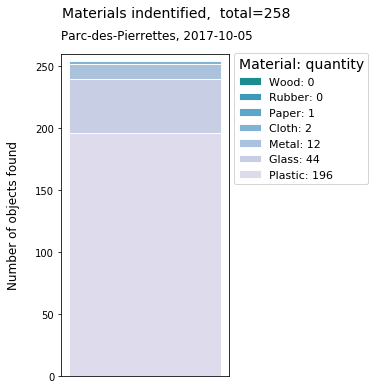

In [30]:
file_names="fig_9_pp_material"
iterateMaterialBarchartBlocksDay(
    pdp_material_block_d,
    p_d_p_total_day,
    day_of_interest,
    "Materials indentified",
    loc_of_interest[0]
)

In [31]:
pdp_source_block_day = makeSourceTotals(p_d_p_day_code, source_groups)
s_s_source_block_day = makeSourceTotals(s_s_day_code, source_groups)

In [32]:
def iterateSourceBarchartBlocksDay(the_data_study, total_quant, date, title_text, sub_title_text):
    fig, ax = plt.subplots(figsize=(3,6))
    my_cmap = plt.cm.get_cmap(this_map,100)
    total_quant = total_quant
    y_limit = total_quant
    y_max = y_limit + 2
    title = "{},  total={:,}".format(title_text, total_quant)
    sub_title = '{}, {}'.format(sub_title_text, date)
    the_bottom = 0
    the_data = [(key,value) for key, value in the_data_study.items()]
    the_data = sorted(the_data, key=lambda x: -x[1])
    color=iter(my_cmap(np.linspace(.2,.75,len(the_data))))   
    for i,block in enumerate(the_data):       
        if i == 0:            
            ax.bar(1, block[1], color=next(color), edgecolor="white", alpha=0.9,
                    label="{}: {:}".format(block[0],block[1]))
            the_bottom += block[1]
        else:            
            ax.bar(1, block[1], color=next(color), edgecolor="white",alpha=0.9,
                   bottom=the_bottom,
                   label="{}: {:}".format(block[0],block[1]))
            the_bottom += block[1]
    plt.subplots_adjust(top=top_adjust)
    plt.xticks([0])
    plt.ylim(0, y_max)
    plt.ylabel('Number of objects found',fontfamily="sans-serif", labelpad=y_label_padding, color=y_label_color, size=y_label_size)
    plt.suptitle(title, fontfamily="sans-serif", fontweight="roman", fontsize=14, x=0.13, ha="left", color=title_color)
    plt.title(sub_title, fontdict=font_styles, pad=pad, x=0, ha="left", color=title_color)
    handles, labels = ax.get_legend_handles_labels()
    this = ax.legend(handles[::-1], labels[::-1], title='Source: quantity',title_fontsize=legend_title_size, fontsize=legend_font_size, bbox_to_anchor=b_box, loc='upper left')
    this._legend_box.align = "left"
    for x in file_suffix:
        save_me = '{}/{}{}'.format(file_prefix, file_names, x)
        plt.savefig(save_me, bbox_inches="tight")     
    plt.show()
    plt.close()  

#### Source Saint Sulpice

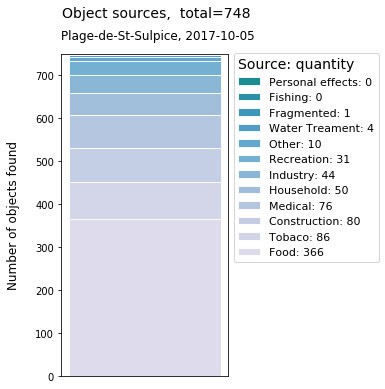

In [33]:
file_names="fig_9_ss_source"
iterateSourceBarchartBlocksDay(
    s_s_source_block_day,
    s_s_total_day,
    day_of_interest,
    "Object sources",
    loc_of_interest[1]
)

#### Source Parc des Pierrettes

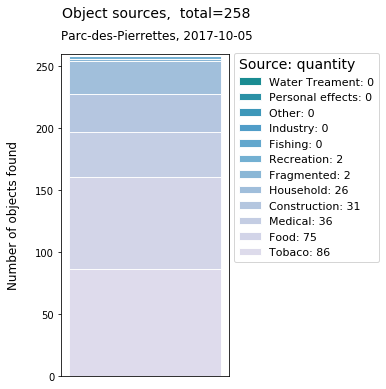

In [34]:
file_names="fig_9_pp_source"
iterateSourceBarchartBlocksDay(
    pdp_source_block_day,
    p_d_p_total_day,
    day_of_interest,
    "Object sources",
    loc_of_interest[0]
)